# INSTALLING AND IMPORTING LIBRARIES

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

# PRE-PROCESSING

All LLMs have a respective prompt template, in order to fine tune an LLM, the dataset must be in this format. For Llama-2, the template is as follows.



*   System prompts are the broad task or persona the LLM will be used for (OPTIONAL)
*   User prompt is the specific example of the broader task (REQUIRED).
*   Model answer (REQUIRED)
*   Tags with 's', "SYS", "INST" must be present in the training dataset.

<br>

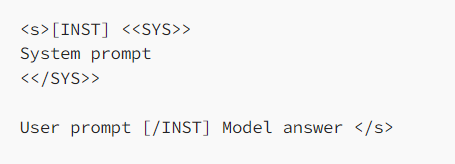

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

In [5]:
%cd /content/drive/My Drive/Colab Notebooks/LLM Fine-Tuning

/content/drive/My Drive/Colab Notebooks/LLM Fine-Tuning


In [19]:
df = pd.read_csv("JEOPARDY_CSV.csv")
df.drop(['Show Number', ' Air Date', ' Round', ' Category', ' Value'], axis=1, inplace=True)

In [20]:
df.head()

,Question,Answer
0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,The city of Yuma in this state has a record av...,Arizona
3,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [21]:
%%time

# Llama format = <s>[INST]<<QUESTION>>[/INST]<<ANSWER>></s>
new_column = []

for i in range(0, df.shape[0]):
  question = df.iloc[i, 0]
  answer = df.iloc[i, 1]
  new_column.append(f"<s>[INST]{question}[/INST]{answer}</s>")

df['text'] = new_column

CPU times: user 12.7 s, sys: 96.1 ms, total: 12.8 s
Wall time: 16.6 s


In [24]:
df.head()

,Question,Answer,text
0,"For the last 8 years of his life, Galileo was ...",Copernicus,"<s>[INST]For the last 8 years of his life, Gal..."
1,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,<s>[INST]No. 2: 1912 Olympian; football star a...
2,The city of Yuma in this state has a record av...,Arizona,<s>[INST]The city of Yuma in this state has a ...
3,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,"<s>[INST]In 1963, live on ""The Art Linkletter ..."
4,"Signer of the Dec. of Indep., framer of the Co...",John Adams,"<s>[INST]Signer of the Dec. of Indep., framer ..."


In [28]:
llama2format_df = df.drop([' Question', ' Answer'], axis=1)

In [29]:
llama2format_df.to_csv("JEOPARDY_CSV_Llama2_Format.csv", index=False)

In [30]:
llama2format_df.head()

,text
0,"<s>[INST]For the last 8 years of his life, Gal..."
1,<s>[INST]No. 2: 1912 Olympian; football star a...
2,<s>[INST]The city of Yuma in this state has a ...
3,"<s>[INST]In 1963, live on ""The Art Linkletter ..."
4,"<s>[INST]Signer of the Dec. of Indep., framer ..."


- We cant do full form fine-tuning since Colab's free resources cant store all the weights + overhead due to optimizer states, gradients, and forward activations.

- So we need PEFT (Parameter-efficient fine-tuning) which uses techniques like LoRA/QLoRA. This lets us fine-tune models in 4-bit precision isntead of original 32-bit.

# SETUP TRAINING PARAMETERS

In [31]:
#LLM Name

llm_name = "NousResearch/Llama-2-7b-chat-hf"
dataset_name = llama2format_df
finetuned_llm_name = "Llama-2-7b-chat-jeopardy"

#QLoRA Params - for PEFT

lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# Bitsandbytes Params - for Quantization (conversion to 4-bit processing)

use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False

# TrainingArguments Params - for model fine-tuning

output_dir = "./results"
num_train_epochs = 1
fp16 = False
bf16 = False #Set to true if strong GPU (like A100)
per_device_train_batch_size = 4
per_device_eval_batch_size = 4
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit" #Variation of ADAM optimzer
lr_scheduler_type = "cosine" #How similarity is determined
max_steps = -1
warmup_ratio = 0.03
group_by_length = True
save_steps = 0
logging_steps = 25

# SFT (Supervised fine-tuning) Params - technique used to adapt pre-trained LLMs for specific tasks

max_seq_length = None
packing = False #Group short training samples as 1 sample to increase efficiency
device_map = {"": 0}

# INITIATE FINE-TUNING